## Mask RCNN

Loading pretrained model

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Define configuration for new dataset


In [5]:
class ClassroomConfig(Config):
    """Configuration for training on the classroom_data dataset.
    Derives from the base Config class and overrides values specific
    to the classroom_data dataset.
    """
    # Give the configuration a recognizable name
    NAME = "classroom"

    # Train on 1 GPU and 2 image per GPU. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    LEARNING_RATE = 0.01

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + person + chair

    # Change this later based on the dimension of images formed from extracting from video
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 704

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 100

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 3
    
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (16, 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = ClassroomConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# Define the dataset


In [6]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets


In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../classroom_data/datasets/video2/train/trainval.json', '../classroom_data/datasets/video2/train/images/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../classroom_data/datasets/video2/test/testval.json', '../classroom_data/datasets/video2/test/images/')
dataset_val.prepare()

## Display a few images from the training dataset

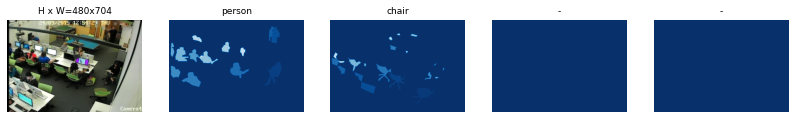

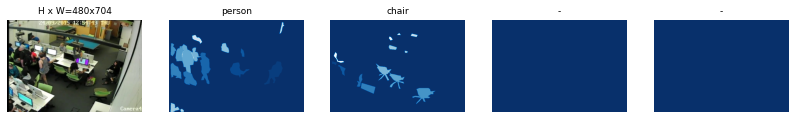

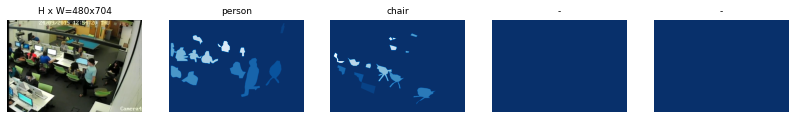

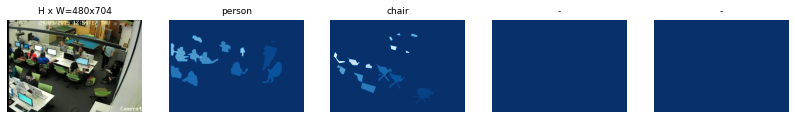

In [8]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train


In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Training
Train in two stages:

1.Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2.Fine-tune all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.01

Checkpoint Path: ../../aktwelve_Mask_RCNN\logs\classroom20210120T0921\mask_rcnn_classroom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_de

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a

  1/100 [..............................] - ETA: 10:58 - batch: 0.0000e+00 - size: 1.0000 - loss: 5.0062 - rpn_class_loss: 0.3455 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 1.8743 - mrcnn_bbox_loss: 1.1097 - mrcnn_mask_loss: 0.9351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 6:06 - batch: 0.5000 - size: 1.0000 - loss: 4.8913 - rpn_class_loss: 0.2743 - rpn_bbox_loss: 0.6772 - mrcnn_class_loss: 1.9980 - mrcnn_bbox_loss: 1.1225 - mrcnn_mask_loss: 0.8192     

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 5:59 - batch: 1.0000 - size: 1.0000 - loss: 4.4783 - rpn_class_loss: 0.2709 - rpn_bbox_loss: 0.6842 - mrcnn_class_loss: 1.6688 - mrcnn_bbox_loss: 1.1044 - mrcnn_mask_loss: 0.7501

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 5:48 - batch: 1.5000 - size: 1.0000 - loss: 4.4331 - rpn_class_loss: 0.2861 - rpn_bbox_loss: 0.6350 - mrcnn_class_loss: 1.7165 - mrcnn_bbox_loss: 1.0872 - mrcnn_mask_loss: 0.7084

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 5:39 - batch: 2.0000 - size: 1.0000 - loss: 4.1918 - rpn_class_loss: 0.2731 - rpn_bbox_loss: 0.6249 - mrcnn_class_loss: 1.5731 - mrcnn_bbox_loss: 1.0335 - mrcnn_mask_loss: 0.6872

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 5:33 - batch: 2.5000 - size: 1.0000 - loss: 4.0589 - rpn_class_loss: 0.2534 - rpn_bbox_loss: 0.6041 - mrcnn_class_loss: 1.5146 - mrcnn_bbox_loss: 1.0171 - mrcnn_mask_loss: 0.6696

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 5:34 - batch: 3.0000 - size: 1.0000 - loss: 3.8951 - rpn_class_loss: 0.2388 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 1.4312 - mrcnn_bbox_loss: 0.9872 - mrcnn_mask_loss: 0.6496

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 5:34 - batch: 3.5000 - size: 1.0000 - loss: 3.7674 - rpn_class_loss: 0.2279 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 1.3685 - mrcnn_bbox_loss: 0.9486 - mrcnn_mask_loss: 0.6371

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 5:31 - batch: 4.0000 - size: 1.0000 - loss: 3.7361 - rpn_class_loss: 0.2182 - rpn_bbox_loss: 0.5750 - mrcnn_class_loss: 1.3458 - mrcnn_bbox_loss: 0.9530 - mrcnn_mask_loss: 0.6442

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 5:26 - batch: 4.5000 - size: 1.0000 - loss: 3.7481 - rpn_class_loss: 0.2111 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 1.3836 - mrcnn_bbox_loss: 0.9404 - mrcnn_mask_loss: 0.6423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 5:24 - batch: 5.0000 - size: 1.0000 - loss: 3.7854 - rpn_class_loss: 0.2171 - rpn_bbox_loss: 0.5770 - mrcnn_class_loss: 1.4251 - mrcnn_bbox_loss: 0.9260 - mrcnn_mask_loss: 0.6403

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 5:21 - batch: 5.5000 - size: 1.0000 - loss: 3.7249 - rpn_class_loss: 0.2100 - rpn_bbox_loss: 0.5900 - mrcnn_class_loss: 1.3716 - mrcnn_bbox_loss: 0.9192 - mrcnn_mask_loss: 0.6341

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 5:17 - batch: 6.0000 - size: 1.0000 - loss: 3.6662 - rpn_class_loss: 0.2133 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 1.3446 - mrcnn_bbox_loss: 0.8897 - mrcnn_mask_loss: 0.6261

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 5:14 - batch: 6.5000 - size: 1.0000 - loss: 3.5879 - rpn_class_loss: 0.2040 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 1.2869 - mrcnn_bbox_loss: 0.8963 - mrcnn_mask_loss: 0.6196

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 5:08 - batch: 7.0000 - size: 1.0000 - loss: 3.5347 - rpn_class_loss: 0.1994 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 1.2712 - mrcnn_bbox_loss: 0.8818 - mrcnn_mask_loss: 0.6102

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 5:05 - batch: 7.5000 - size: 1.0000 - loss: 3.5035 - rpn_class_loss: 0.2016 - rpn_bbox_loss: 0.5797 - mrcnn_class_loss: 1.2487 - mrcnn_bbox_loss: 0.8684 - mrcnn_mask_loss: 0.6052

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 5:02 - batch: 8.0000 - size: 1.0000 - loss: 3.4886 - rpn_class_loss: 0.1960 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 1.2425 - mrcnn_bbox_loss: 0.8731 - mrcnn_mask_loss: 0.6033

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 4:58 - batch: 8.5000 - size: 1.0000 - loss: 3.4531 - rpn_class_loss: 0.1930 - rpn_bbox_loss: 0.5700 - mrcnn_class_loss: 1.2226 - mrcnn_bbox_loss: 0.8652 - mrcnn_mask_loss: 0.6022

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 4:57 - batch: 9.0000 - size: 1.0000 - loss: 3.4340 - rpn_class_loss: 0.1937 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 1.2107 - mrcnn_bbox_loss: 0.8649 - mrcnn_mask_loss: 0.6002

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 4:56 - batch: 9.5000 - size: 1.0000 - loss: 3.3678 - rpn_class_loss: 0.1887 - rpn_bbox_loss: 0.5589 - mrcnn_class_loss: 1.1769 - mrcnn_bbox_loss: 0.8479 - mrcnn_mask_loss: 0.5954

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 4:53 - batch: 10.0000 - size: 1.0000 - loss: 3.3406 - rpn_class_loss: 0.1843 - rpn_bbox_loss: 0.5524 - mrcnn_class_loss: 1.1524 - mrcnn_bbox_loss: 0.8607 - mrcnn_mask_loss: 0.5908

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 4:50 - batch: 10.5000 - size: 1.0000 - loss: 3.3107 - rpn_class_loss: 0.1818 - rpn_bbox_loss: 0.5471 - mrcnn_class_loss: 1.1404 - mrcnn_bbox_loss: 0.8565 - mrcnn_mask_loss: 0.5849

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 4:47 - batch: 11.0000 - size: 1.0000 - loss: 3.2680 - rpn_class_loss: 0.1803 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 1.1209 - mrcnn_bbox_loss: 0.8414 - mrcnn_mask_loss: 0.5799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 4:44 - batch: 11.5000 - size: 1.0000 - loss: 3.2449 - rpn_class_loss: 0.1773 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 1.1085 - mrcnn_bbox_loss: 0.8436 - mrcnn_mask_loss: 0.5736

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 4:40 - batch: 12.0000 - size: 1.0000 - loss: 3.2072 - rpn_class_loss: 0.1729 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 1.0844 - mrcnn_bbox_loss: 0.8421 - mrcnn_mask_loss: 0.5680

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 4:37 - batch: 12.5000 - size: 1.0000 - loss: 3.1965 - rpn_class_loss: 0.1724 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 1.0650 - mrcnn_bbox_loss: 0.8428 - mrcnn_mask_loss: 0.5767

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 4:35 - batch: 13.0000 - size: 1.0000 - loss: 3.1533 - rpn_class_loss: 0.1696 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 1.0400 - mrcnn_bbox_loss: 0.8380 - mrcnn_mask_loss: 0.5726

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 4:31 - batch: 13.5000 - size: 1.0000 - loss: 3.1470 - rpn_class_loss: 0.1681 - rpn_bbox_loss: 0.5286 - mrcnn_class_loss: 1.0421 - mrcnn_bbox_loss: 0.8391 - mrcnn_mask_loss: 0.5692

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 4:28 - batch: 14.0000 - size: 1.0000 - loss: 3.1131 - rpn_class_loss: 0.1659 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 1.0165 - mrcnn_bbox_loss: 0.8405 - mrcnn_mask_loss: 0.5664

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 4:24 - batch: 14.5000 - size: 1.0000 - loss: 3.0801 - rpn_class_loss: 0.1647 - rpn_bbox_loss: 0.5213 - mrcnn_class_loss: 0.9918 - mrcnn_bbox_loss: 0.8383 - mrcnn_mask_loss: 0.5640

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 4:21 - batch: 15.0000 - size: 1.0000 - loss: 3.0560 - rpn_class_loss: 0.1638 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.9729 - mrcnn_bbox_loss: 0.8377 - mrcnn_mask_loss: 0.5577

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 4:17 - batch: 15.5000 - size: 1.0000 - loss: 3.0220 - rpn_class_loss: 0.1616 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.9532 - mrcnn_bbox_loss: 0.8316 - mrcnn_mask_loss: 0.5562

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 4:14 - batch: 16.0000 - size: 1.0000 - loss: 3.0091 - rpn_class_loss: 0.1607 - rpn_bbox_loss: 0.5166 - mrcnn_class_loss: 0.9513 - mrcnn_bbox_loss: 0.8275 - mrcnn_mask_loss: 0.5530

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 4:09 - batch: 16.5000 - size: 1.0000 - loss: 2.9852 - rpn_class_loss: 0.1599 - rpn_bbox_loss: 0.5169 - mrcnn_class_loss: 0.9384 - mrcnn_bbox_loss: 0.8215 - mrcnn_mask_loss: 0.5484

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 4:06 - batch: 17.0000 - size: 1.0000 - loss: 2.9765 - rpn_class_loss: 0.1572 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.9437 - mrcnn_bbox_loss: 0.8188 - mrcnn_mask_loss: 0.5448

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 4:02 - batch: 17.5000 - size: 1.0000 - loss: 2.9504 - rpn_class_loss: 0.1557 - rpn_bbox_loss: 0.5116 - mrcnn_class_loss: 0.9279 - mrcnn_bbox_loss: 0.8143 - mrcnn_mask_loss: 0.5408

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 3:58 - batch: 18.0000 - size: 1.0000 - loss: 2.9330 - rpn_class_loss: 0.1552 - rpn_bbox_loss: 0.5104 - mrcnn_class_loss: 0.9182 - mrcnn_bbox_loss: 0.8078 - mrcnn_mask_loss: 0.5414

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 3:55 - batch: 18.5000 - size: 1.0000 - loss: 2.9095 - rpn_class_loss: 0.1529 - rpn_bbox_loss: 0.5077 - mrcnn_class_loss: 0.9054 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 0.5365

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 3:52 - batch: 19.0000 - size: 1.0000 - loss: 2.9129 - rpn_class_loss: 0.1512 - rpn_bbox_loss: 0.5058 - mrcnn_class_loss: 0.9140 - mrcnn_bbox_loss: 0.8031 - mrcnn_mask_loss: 0.5388

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 3:49 - batch: 19.5000 - size: 1.0000 - loss: 2.9098 - rpn_class_loss: 0.1516 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.9099 - mrcnn_bbox_loss: 0.8047 - mrcnn_mask_loss: 0.5367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 3:46 - batch: 20.0000 - size: 1.0000 - loss: 2.9001 - rpn_class_loss: 0.1519 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.9067 - mrcnn_bbox_loss: 0.7991 - mrcnn_mask_loss: 0.5355

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 3:42 - batch: 20.5000 - size: 1.0000 - loss: 2.8970 - rpn_class_loss: 0.1499 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.9008 - mrcnn_bbox_loss: 0.8017 - mrcnn_mask_loss: 0.5329

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 3:39 - batch: 21.0000 - size: 1.0000 - loss: 2.8819 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 0.5103 - mrcnn_class_loss: 0.8905 - mrcnn_bbox_loss: 0.8004 - mrcnn_mask_loss: 0.5313

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 3:35 - batch: 21.5000 - size: 1.0000 - loss: 2.8661 - rpn_class_loss: 0.1478 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.8822 - mrcnn_bbox_loss: 0.7962 - mrcnn_mask_loss: 0.5301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 3:32 - batch: 22.0000 - size: 1.0000 - loss: 2.8545 - rpn_class_loss: 0.1483 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.8768 - mrcnn_bbox_loss: 0.7903 - mrcnn_mask_loss: 0.5276

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 3:28 - batch: 22.5000 - size: 1.0000 - loss: 2.8462 - rpn_class_loss: 0.1478 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.8760 - mrcnn_bbox_loss: 0.7854 - mrcnn_mask_loss: 0.5250

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 3:24 - batch: 23.0000 - size: 1.0000 - loss: 2.8278 - rpn_class_loss: 0.1467 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.8710 - mrcnn_bbox_loss: 0.7785 - mrcnn_mask_loss: 0.5214

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 3:20 - batch: 23.5000 - size: 1.0000 - loss: 2.8006 - rpn_class_loss: 0.1452 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.8577 - mrcnn_bbox_loss: 0.7711 - mrcnn_mask_loss: 0.5176

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 3:16 - batch: 24.0000 - size: 1.0000 - loss: 2.7843 - rpn_class_loss: 0.1443 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.8492 - mrcnn_bbox_loss: 0.7686 - mrcnn_mask_loss: 0.5126

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 3:13 - batch: 24.5000 - size: 1.0000 - loss: 2.7629 - rpn_class_loss: 0.1428 - rpn_bbox_loss: 0.5077 - mrcnn_class_loss: 0.8396 - mrcnn_bbox_loss: 0.7633 - mrcnn_mask_loss: 0.5094

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 3:09 - batch: 25.0000 - size: 1.0000 - loss: 2.7434 - rpn_class_loss: 0.1417 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.8311 - mrcnn_bbox_loss: 0.7591 - mrcnn_mask_loss: 0.5044

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 3:05 - batch: 25.5000 - size: 1.0000 - loss: 2.7350 - rpn_class_loss: 0.1401 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.8265 - mrcnn_bbox_loss: 0.7587 - mrcnn_mask_loss: 0.5028

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 3:01 - batch: 26.0000 - size: 1.0000 - loss: 2.7244 - rpn_class_loss: 0.1393 - rpn_bbox_loss: 0.5065 - mrcnn_class_loss: 0.8221 - mrcnn_bbox_loss: 0.7546 - mrcnn_mask_loss: 0.5019

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 2:58 - batch: 26.5000 - size: 1.0000 - loss: 2.7176 - rpn_class_loss: 0.1382 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.8235 - mrcnn_bbox_loss: 0.7512 - mrcnn_mask_loss: 0.5016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 2:54 - batch: 27.0000 - size: 1.0000 - loss: 2.7076 - rpn_class_loss: 0.1368 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.8224 - mrcnn_bbox_loss: 0.7492 - mrcnn_mask_loss: 0.4978

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 2:50 - batch: 27.5000 - size: 1.0000 - loss: 2.6931 - rpn_class_loss: 0.1357 - rpn_bbox_loss: 0.4989 - mrcnn_class_loss: 0.8157 - mrcnn_bbox_loss: 0.7468 - mrcnn_mask_loss: 0.4961

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 2:46 - batch: 28.0000 - size: 1.0000 - loss: 2.6815 - rpn_class_loss: 0.1351 - rpn_bbox_loss: 0.4972 - mrcnn_class_loss: 0.8121 - mrcnn_bbox_loss: 0.7427 - mrcnn_mask_loss: 0.4944

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 2:42 - batch: 28.5000 - size: 1.0000 - loss: 2.6709 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 0.4947 - mrcnn_class_loss: 0.8103 - mrcnn_bbox_loss: 0.7388 - mrcnn_mask_loss: 0.4930

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 2:38 - batch: 29.0000 - size: 1.0000 - loss: 2.6544 - rpn_class_loss: 0.1329 - rpn_bbox_loss: 0.4918 - mrcnn_class_loss: 0.8029 - mrcnn_bbox_loss: 0.7355 - mrcnn_mask_loss: 0.4913

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 2:33 - batch: 29.5000 - size: 1.0000 - loss: 2.6421 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 0.4904 - mrcnn_class_loss: 0.7989 - mrcnn_bbox_loss: 0.7318 - mrcnn_mask_loss: 0.4890

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 2:30 - batch: 30.0000 - size: 1.0000 - loss: 2.6296 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 0.4905 - mrcnn_class_loss: 0.7948 - mrcnn_bbox_loss: 0.7276 - mrcnn_mask_loss: 0.4865

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 2:25 - batch: 30.5000 - size: 1.0000 - loss: 2.6103 - rpn_class_loss: 0.1296 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.7859 - mrcnn_bbox_loss: 0.7224 - mrcnn_mask_loss: 0.4835

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 2:22 - batch: 31.0000 - size: 1.0000 - loss: 2.6137 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 0.4910 - mrcnn_class_loss: 0.7891 - mrcnn_bbox_loss: 0.7230 - mrcnn_mask_loss: 0.4821

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 2:18 - batch: 31.5000 - size: 1.0000 - loss: 2.6043 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.7848 - mrcnn_bbox_loss: 0.7223 - mrcnn_mask_loss: 0.4801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 2:14 - batch: 32.0000 - size: 1.0000 - loss: 2.5903 - rpn_class_loss: 0.1256 - rpn_bbox_loss: 0.4880 - mrcnn_class_loss: 0.7786 - mrcnn_bbox_loss: 0.7192 - mrcnn_mask_loss: 0.4789

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 2:10 - batch: 32.5000 - size: 1.0000 - loss: 2.5793 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 0.4896 - mrcnn_class_loss: 0.7713 - mrcnn_bbox_loss: 0.7166 - mrcnn_mask_loss: 0.4766

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 2:06 - batch: 33.0000 - size: 1.0000 - loss: 2.5721 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 0.4895 - mrcnn_class_loss: 0.7662 - mrcnn_bbox_loss: 0.7164 - mrcnn_mask_loss: 0.4752

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 2:02 - batch: 33.5000 - size: 1.0000 - loss: 2.5590 - rpn_class_loss: 0.1241 - rpn_bbox_loss: 0.4881 - mrcnn_class_loss: 0.7612 - mrcnn_bbox_loss: 0.7116 - mrcnn_mask_loss: 0.4739

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 1:58 - batch: 34.0000 - size: 1.0000 - loss: 2.5546 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 0.4870 - mrcnn_class_loss: 0.7587 - mrcnn_bbox_loss: 0.7129 - mrcnn_mask_loss: 0.4727

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 1:54 - batch: 34.5000 - size: 1.0000 - loss: 2.5510 - rpn_class_loss: 0.1229 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.7570 - mrcnn_bbox_loss: 0.7107 - mrcnn_mask_loss: 0.4714

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 1:51 - batch: 35.0000 - size: 1.0000 - loss: 2.5531 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.7590 - mrcnn_bbox_loss: 0.7123 - mrcnn_mask_loss: 0.4695

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 1:47 - batch: 35.5000 - size: 1.0000 - loss: 2.5429 - rpn_class_loss: 0.1212 - rpn_bbox_loss: 0.4888 - mrcnn_class_loss: 0.7552 - mrcnn_bbox_loss: 0.7107 - mrcnn_mask_loss: 0.4669

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 1:43 - batch: 36.0000 - size: 1.0000 - loss: 2.5298 - rpn_class_loss: 0.1204 - rpn_bbox_loss: 0.4881 - mrcnn_class_loss: 0.7510 - mrcnn_bbox_loss: 0.7053 - mrcnn_mask_loss: 0.4650

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 1:39 - batch: 36.5000 - size: 1.0000 - loss: 2.5245 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.4863 - mrcnn_class_loss: 0.7476 - mrcnn_bbox_loss: 0.7074 - mrcnn_mask_loss: 0.4635

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 1:35 - batch: 37.0000 - size: 1.0000 - loss: 2.5179 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 0.4855 - mrcnn_class_loss: 0.7464 - mrcnn_bbox_loss: 0.7040 - mrcnn_mask_loss: 0.4626

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 1:32 - batch: 37.5000 - size: 1.0000 - loss: 2.5108 - rpn_class_loss: 0.1187 - rpn_bbox_loss: 0.4858 - mrcnn_class_loss: 0.7445 - mrcnn_bbox_loss: 0.7017 - mrcnn_mask_loss: 0.4601

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 1:28 - batch: 38.0000 - size: 1.0000 - loss: 2.5058 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.7404 - mrcnn_bbox_loss: 0.7005 - mrcnn_mask_loss: 0.4587

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 1:24 - batch: 38.5000 - size: 1.0000 - loss: 2.5055 - rpn_class_loss: 0.1195 - rpn_bbox_loss: 0.4922 - mrcnn_class_loss: 0.7384 - mrcnn_bbox_loss: 0.6988 - mrcnn_mask_loss: 0.4566

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 1:20 - batch: 39.0000 - size: 1.0000 - loss: 2.4964 - rpn_class_loss: 0.1186 - rpn_bbox_loss: 0.4928 - mrcnn_class_loss: 0.7340 - mrcnn_bbox_loss: 0.6961 - mrcnn_mask_loss: 0.4548

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 1:16 - batch: 39.5000 - size: 1.0000 - loss: 2.4858 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.4916 - mrcnn_class_loss: 0.7303 - mrcnn_bbox_loss: 0.6934 - mrcnn_mask_loss: 0.4526

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 1:13 - batch: 40.0000 - size: 1.0000 - loss: 2.4806 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 0.4908 - mrcnn_class_loss: 0.7282 - mrcnn_bbox_loss: 0.6914 - mrcnn_mask_loss: 0.4525

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 1:09 - batch: 40.5000 - size: 1.0000 - loss: 2.4717 - rpn_class_loss: 0.1174 - rpn_bbox_loss: 0.4899 - mrcnn_class_loss: 0.7256 - mrcnn_bbox_loss: 0.6889 - mrcnn_mask_loss: 0.4499

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:05 - batch: 41.0000 - size: 1.0000 - loss: 2.4693 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.7249 - mrcnn_bbox_loss: 0.6890 - mrcnn_mask_loss: 0.4479

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:01 - batch: 41.5000 - size: 1.0000 - loss: 2.4668 - rpn_class_loss: 0.1164 - rpn_bbox_loss: 0.4918 - mrcnn_class_loss: 0.7241 - mrcnn_bbox_loss: 0.6887 - mrcnn_mask_loss: 0.4458

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 57s - batch: 42.0000 - size: 1.0000 - loss: 2.4647 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.7246 - mrcnn_bbox_loss: 0.6858 - mrcnn_mask_loss: 0.4444 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 54s - batch: 42.5000 - size: 1.0000 - loss: 2.4602 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.4945 - mrcnn_class_loss: 0.7218 - mrcnn_bbox_loss: 0.6851 - mrcnn_mask_loss: 0.4431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 50s - batch: 43.0000 - size: 1.0000 - loss: 2.4585 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.7214 - mrcnn_bbox_loss: 0.6845 - mrcnn_mask_loss: 0.4420

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 46s - batch: 43.5000 - size: 1.0000 - loss: 2.4485 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.7161 - mrcnn_bbox_loss: 0.6824 - mrcnn_mask_loss: 0.4396

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 42s - batch: 44.0000 - size: 1.0000 - loss: 2.4393 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.7109 - mrcnn_bbox_loss: 0.6804 - mrcnn_mask_loss: 0.4380

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 38s - batch: 44.5000 - size: 1.0000 - loss: 2.4369 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 0.4956 - mrcnn_class_loss: 0.7102 - mrcnn_bbox_loss: 0.6800 - mrcnn_mask_loss: 0.4358

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 34s - batch: 45.0000 - size: 1.0000 - loss: 2.4330 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.4964 - mrcnn_class_loss: 0.7088 - mrcnn_bbox_loss: 0.6783 - mrcnn_mask_loss: 0.4343

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 30s - batch: 45.5000 - size: 1.0000 - loss: 2.4270 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.7058 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.4335

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 26s - batch: 46.0000 - size: 1.0000 - loss: 2.4225 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.4948 - mrcnn_class_loss: 0.7049 - mrcnn_bbox_loss: 0.6746 - mrcnn_mask_loss: 0.4328

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 23s - batch: 46.5000 - size: 1.0000 - loss: 2.4133 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 0.4947 - mrcnn_class_loss: 0.6999 - mrcnn_bbox_loss: 0.6722 - mrcnn_mask_loss: 0.4307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 19s - batch: 47.0000 - size: 1.0000 - loss: 2.4075 - rpn_class_loss: 0.1161 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.6957 - mrcnn_bbox_loss: 0.6698 - mrcnn_mask_loss: 0.4307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 15s - batch: 47.5000 - size: 1.0000 - loss: 2.4035 - rpn_class_loss: 0.1163 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.6939 - mrcnn_bbox_loss: 0.6689 - mrcnn_mask_loss: 0.4303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 11s - batch: 48.0000 - size: 1.0000 - loss: 2.4008 - rpn_class_loss: 0.1165 - rpn_bbox_loss: 0.4945 - mrcnn_class_loss: 0.6909 - mrcnn_bbox_loss: 0.6694 - mrcnn_mask_loss: 0.4296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 7s - batch: 48.5000 - size: 1.0000 - loss: 2.3955 - rpn_class_loss: 0.1162 - rpn_bbox_loss: 0.4944 - mrcnn_class_loss: 0.6878 - mrcnn_bbox_loss: 0.6685 - mrcnn_mask_loss: 0.4285 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 3s - batch: 49.0000 - size: 1.0000 - loss: 2.3922 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.6885 - mrcnn_bbox_loss: 0.6673 - mrcnn_mask_loss: 0.4270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 2.3886 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.4939 - mrcnn_class_loss: 0.6845 - mrcnn_bbox_loss: 0.6681 - mrcnn_mask_loss: 0.4262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data

100/100 [==============================] - 400s 4s/step - batch: 49.5000 - size: 1.0000 - loss: 2.3886 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.4939 - mrcnn_class_loss: 0.6845 - mrcnn_bbox_loss: 0.6681 - mrcnn_mask_loss: 0.4262 - val_loss: 2.1119 - val_rpn_class_loss: 0.1142 - val_rpn_bbox_loss: 0.6500 - val_mrcnn_class_loss: 0.4011 - val_mrcnn_bbox_loss: 0.6070 - val_mrcnn_mask_loss: 0.3396
Epoch 2/3


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 5:38 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.6992 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.2284 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.3494

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 6:05 - batch: 0.5000 - size: 1.0000 - loss: 1.7239 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.5426 - mrcnn_mask_loss: 0.3008    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 6:03 - batch: 1.0000 - size: 1.0000 - loss: 1.8541 - rpn_class_loss: 0.1186 - rpn_bbox_loss: 0.5152 - mrcnn_class_loss: 0.4127 - mrcnn_bbox_loss: 0.5122 - mrcnn_mask_loss: 0.2955

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 6:00 - batch: 1.5000 - size: 1.0000 - loss: 1.9175 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.4542 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.3289

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 5:57 - batch: 2.0000 - size: 1.0000 - loss: 1.8977 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.4659 - mrcnn_class_loss: 0.4854 - mrcnn_bbox_loss: 0.5358 - mrcnn_mask_loss: 0.3175

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 5:53 - batch: 2.5000 - size: 1.0000 - loss: 1.9442 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 0.4403 - mrcnn_class_loss: 0.5221 - mrcnn_bbox_loss: 0.5561 - mrcnn_mask_loss: 0.3380

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 5:47 - batch: 3.0000 - size: 1.0000 - loss: 1.9262 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.4548 - mrcnn_class_loss: 0.5102 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.3360

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 5:47 - batch: 3.5000 - size: 1.0000 - loss: 1.8885 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.4542 - mrcnn_class_loss: 0.4938 - mrcnn_bbox_loss: 0.5264 - mrcnn_mask_loss: 0.3246

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 5:41 - batch: 4.0000 - size: 1.0000 - loss: 1.8727 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.4783 - mrcnn_class_loss: 0.4628 - mrcnn_bbox_loss: 0.5161 - mrcnn_mask_loss: 0.3267

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 5:36 - batch: 4.5000 - size: 1.0000 - loss: 1.8398 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.4895 - mrcnn_class_loss: 0.4390 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.3185

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 5:32 - batch: 5.0000 - size: 1.0000 - loss: 1.9371 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.4532 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.3435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 5:28 - batch: 5.5000 - size: 1.0000 - loss: 1.9475 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 0.5113 - mrcnn_class_loss: 0.4710 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.3439

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 5:26 - batch: 6.0000 - size: 1.0000 - loss: 1.9307 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.4545 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.3418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 5:22 - batch: 6.5000 - size: 1.0000 - loss: 1.9381 - rpn_class_loss: 0.0981 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.4641 - mrcnn_bbox_loss: 0.5208 - mrcnn_mask_loss: 0.3535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 5:18 - batch: 7.0000 - size: 1.0000 - loss: 1.9529 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.4781 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.3652

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 5:15 - batch: 7.5000 - size: 1.0000 - loss: 1.9613 - rpn_class_loss: 0.0957 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.4796 - mrcnn_bbox_loss: 0.5165 - mrcnn_mask_loss: 0.3649

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 5:13 - batch: 8.0000 - size: 1.0000 - loss: 1.9652 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.4831 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.3651

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 5:09 - batch: 8.5000 - size: 1.0000 - loss: 1.9661 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.4703 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.3663

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 5:07 - batch: 9.0000 - size: 1.0000 - loss: 1.9744 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.4668 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.3667

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 5:03 - batch: 9.5000 - size: 1.0000 - loss: 1.9828 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 0.5354 - mrcnn_class_loss: 0.4581 - mrcnn_bbox_loss: 0.5308 - mrcnn_mask_loss: 0.3646

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 5:00 - batch: 10.0000 - size: 1.0000 - loss: 1.9778 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.4576 - mrcnn_bbox_loss: 0.5338 - mrcnn_mask_loss: 0.3646

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 4:57 - batch: 10.5000 - size: 1.0000 - loss: 2.0001 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 0.5476 - mrcnn_mask_loss: 0.3605

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 4:53 - batch: 11.0000 - size: 1.0000 - loss: 1.9956 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 0.5224 - mrcnn_class_loss: 0.4761 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.3550

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 4:50 - batch: 11.5000 - size: 1.0000 - loss: 1.9934 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.5231 - mrcnn_class_loss: 0.4763 - mrcnn_bbox_loss: 0.5475 - mrcnn_mask_loss: 0.3546

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 4:46 - batch: 12.0000 - size: 1.0000 - loss: 1.9933 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.5199 - mrcnn_class_loss: 0.4802 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.3534

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 4:41 - batch: 12.5000 - size: 1.0000 - loss: 2.0055 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.5277 - mrcnn_class_loss: 0.4863 - mrcnn_bbox_loss: 0.5469 - mrcnn_mask_loss: 0.3530

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 4:37 - batch: 13.0000 - size: 1.0000 - loss: 2.0008 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4853 - mrcnn_bbox_loss: 0.5377 - mrcnn_mask_loss: 0.3517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 4:33 - batch: 13.5000 - size: 1.0000 - loss: 1.9997 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.4885 - mrcnn_bbox_loss: 0.5352 - mrcnn_mask_loss: 0.3522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 4:29 - batch: 14.0000 - size: 1.0000 - loss: 2.0161 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.4983 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.3533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 4:26 - batch: 14.5000 - size: 1.0000 - loss: 2.0057 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 0.5289 - mrcnn_class_loss: 0.4981 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.3534

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 4:22 - batch: 15.0000 - size: 1.0000 - loss: 2.0079 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.5017 - mrcnn_bbox_loss: 0.5353 - mrcnn_mask_loss: 0.3512

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 4:18 - batch: 15.5000 - size: 1.0000 - loss: 2.0028 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.5377 - mrcnn_class_loss: 0.4941 - mrcnn_bbox_loss: 0.5330 - mrcnn_mask_loss: 0.3498

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 4:14 - batch: 16.0000 - size: 1.0000 - loss: 1.9967 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4914 - mrcnn_bbox_loss: 0.5340 - mrcnn_mask_loss: 0.3485

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 4:10 - batch: 16.5000 - size: 1.0000 - loss: 2.0050 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.5317 - mrcnn_class_loss: 0.5005 - mrcnn_bbox_loss: 0.5355 - mrcnn_mask_loss: 0.3512

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 4:07 - batch: 17.0000 - size: 1.0000 - loss: 1.9980 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.5286 - mrcnn_class_loss: 0.4965 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.3502

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 4:03 - batch: 17.5000 - size: 1.0000 - loss: 2.0168 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.5252 - mrcnn_class_loss: 0.5122 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.3507

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 3:59 - batch: 18.0000 - size: 1.0000 - loss: 2.0110 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.5208 - mrcnn_class_loss: 0.5142 - mrcnn_bbox_loss: 0.5435 - mrcnn_mask_loss: 0.3480

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 3:55 - batch: 18.5000 - size: 1.0000 - loss: 2.0101 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.5157 - mrcnn_bbox_loss: 0.5419 - mrcnn_mask_loss: 0.3476

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 3:51 - batch: 19.0000 - size: 1.0000 - loss: 2.0173 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.5223 - mrcnn_class_loss: 0.5215 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.3454

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 3:47 - batch: 19.5000 - size: 1.0000 - loss: 2.0216 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.5175 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.3435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 3:44 - batch: 20.0000 - size: 1.0000 - loss: 2.0142 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.5267 - mrcnn_class_loss: 0.5144 - mrcnn_bbox_loss: 0.5442 - mrcnn_mask_loss: 0.3417

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 3:40 - batch: 20.5000 - size: 1.0000 - loss: 2.0165 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 0.5282 - mrcnn_class_loss: 0.5154 - mrcnn_bbox_loss: 0.5437 - mrcnn_mask_loss: 0.3414

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 3:36 - batch: 21.0000 - size: 1.0000 - loss: 2.0078 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.5265 - mrcnn_class_loss: 0.5124 - mrcnn_bbox_loss: 0.5421 - mrcnn_mask_loss: 0.3383

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 3:33 - batch: 21.5000 - size: 1.0000 - loss: 2.0074 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.5280 - mrcnn_class_loss: 0.5111 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.3379

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 3:29 - batch: 22.0000 - size: 1.0000 - loss: 2.0139 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.5167 - mrcnn_bbox_loss: 0.5456 - mrcnn_mask_loss: 0.3351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 3:25 - batch: 22.5000 - size: 1.0000 - loss: 2.0111 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.5262 - mrcnn_class_loss: 0.5162 - mrcnn_bbox_loss: 0.5438 - mrcnn_mask_loss: 0.3337

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 3:21 - batch: 23.0000 - size: 1.0000 - loss: 2.0258 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.5226 - mrcnn_bbox_loss: 0.5504 - mrcnn_mask_loss: 0.3344

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 3:18 - batch: 23.5000 - size: 1.0000 - loss: 2.0364 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.5237 - mrcnn_bbox_loss: 0.5562 - mrcnn_mask_loss: 0.3332

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 3:14 - batch: 24.0000 - size: 1.0000 - loss: 2.0379 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.5299 - mrcnn_class_loss: 0.5293 - mrcnn_bbox_loss: 0.5552 - mrcnn_mask_loss: 0.3320

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 3:10 - batch: 24.5000 - size: 1.0000 - loss: 2.0528 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.5261 - mrcnn_bbox_loss: 0.5574 - mrcnn_mask_loss: 0.3318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 3:06 - batch: 25.0000 - size: 1.0000 - loss: 2.0686 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.5507 - mrcnn_class_loss: 0.5301 - mrcnn_bbox_loss: 0.5612 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 3:02 - batch: 25.5000 - size: 1.0000 - loss: 2.0683 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.5284 - mrcnn_bbox_loss: 0.5613 - mrcnn_mask_loss: 0.3354

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 2:59 - batch: 26.0000 - size: 1.0000 - loss: 2.0765 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.5507 - mrcnn_class_loss: 0.5316 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.3361

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 2:55 - batch: 26.5000 - size: 1.0000 - loss: 2.0730 - rpn_class_loss: 0.0935 - rpn_bbox_loss: 0.5497 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.5629 - mrcnn_mask_loss: 0.3372

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 2:51 - batch: 27.0000 - size: 1.0000 - loss: 2.0730 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.5497 - mrcnn_class_loss: 0.5313 - mrcnn_bbox_loss: 0.5614 - mrcnn_mask_loss: 0.3370

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 2:47 - batch: 27.5000 - size: 1.0000 - loss: 2.0733 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.5500 - mrcnn_class_loss: 0.5323 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.3372

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 2:43 - batch: 28.0000 - size: 1.0000 - loss: 2.0686 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.5481 - mrcnn_class_loss: 0.5304 - mrcnn_bbox_loss: 0.5604 - mrcnn_mask_loss: 0.3371

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 2:39 - batch: 28.5000 - size: 1.0000 - loss: 2.0660 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 0.5489 - mrcnn_class_loss: 0.5275 - mrcnn_bbox_loss: 0.5593 - mrcnn_mask_loss: 0.3375

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 2:35 - batch: 29.0000 - size: 1.0000 - loss: 2.0640 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.5478 - mrcnn_class_loss: 0.5261 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 0.3368

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 2:31 - batch: 29.5000 - size: 1.0000 - loss: 2.0523 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.5470 - mrcnn_class_loss: 0.5200 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.3356

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 2:28 - batch: 30.0000 - size: 1.0000 - loss: 2.0532 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.5183 - mrcnn_bbox_loss: 0.5605 - mrcnn_mask_loss: 0.3353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 2:24 - batch: 30.5000 - size: 1.0000 - loss: 2.0559 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.5194 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.3347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 2:20 - batch: 31.0000 - size: 1.0000 - loss: 2.0518 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.5167 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.3356

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 2:16 - batch: 31.5000 - size: 1.0000 - loss: 2.0544 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.5483 - mrcnn_class_loss: 0.5206 - mrcnn_bbox_loss: 0.5586 - mrcnn_mask_loss: 0.3351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


# Prepare to run Inference

In [42]:
class InferenceConfig(ClassroomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 704
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [43]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [44]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../aktwelve_Mask_RCNN\logs\classroom20210120T0109\mask_rcnn_classroom_0004.h5
Re-starting from epoch 4


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


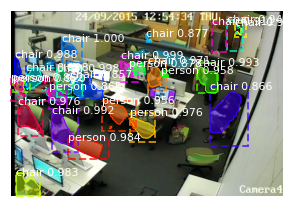

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


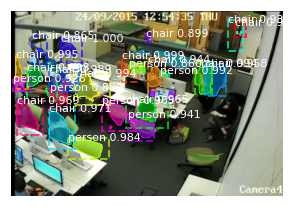

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


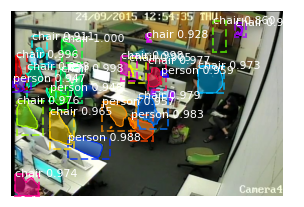

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


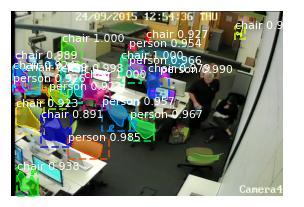

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


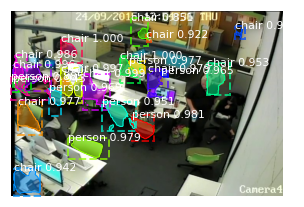

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


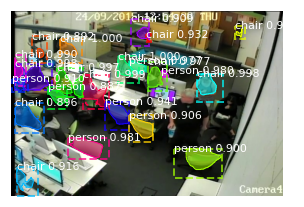

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


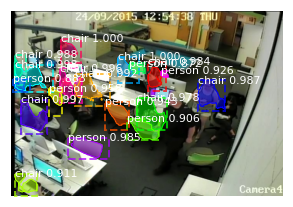

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


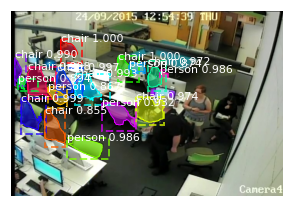

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


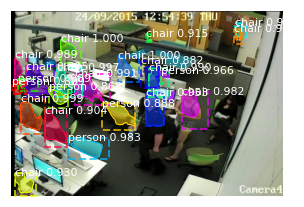

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


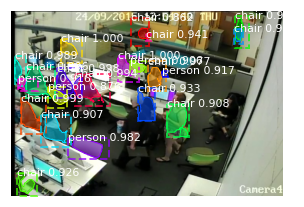

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


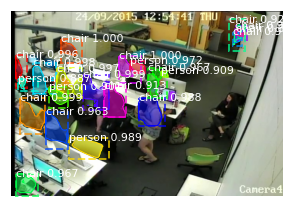

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


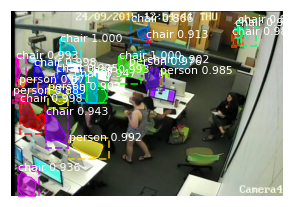

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


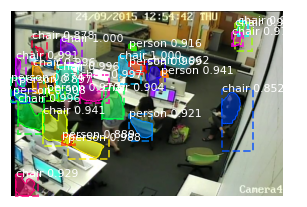

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


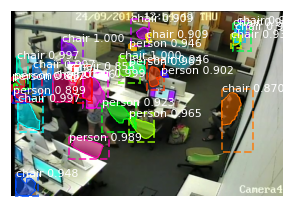

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


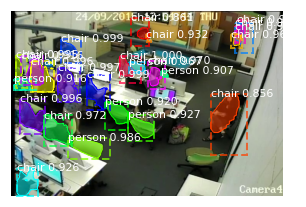

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


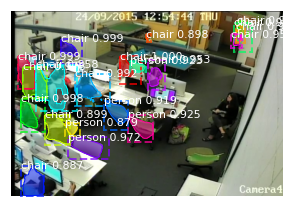

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


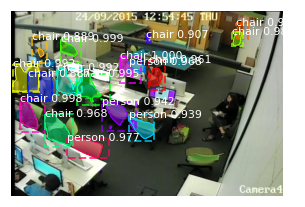

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


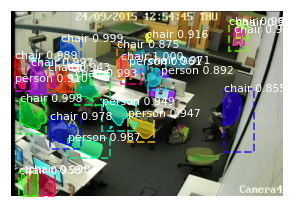

In [47]:
import skimage
real_test_dir = '../classroom_data/datasets/video2/real_test/' #change this location of test_dir
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))